In [107]:
import os
import sys
import csv
import ast
import json
from datetime import datetime
import numpy as np
import pandas as pd

# import chart_studio
# import chart_studio.plotly as py
# import plotly.graph_objects as go
# chart_studio.tools.set_credentials_file(username='mhsjacoby', api_key='1t4R0HFMmZpUPCJosdJQ')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize']=(18, 10)
sns.set()
sns.set_context()
sns.set_palette(sns.color_palette("deep"))

import collections
HomeObj = collections.namedtuple('HomeObj', 'name sensors pi')

In [3]:
class HomeData():
    def __init__(self, path):
        self.root_dir = path
        self.summary_dir = self.make_storage_directory(os.path.join(self.root_dir, 'DataSummaries'))
        self.home = path.split('/')[-1].split('-')[-2]
        self.system = path.split('/')[-1].split('-')[-1]

    
    def mylistdir(self, directory, bit='', end=True):
        filelist = os.listdir(directory)
        if end:
            return [x for x in filelist if x.endswith(f'{bit}') and not x.endswith('.DS_Store') and not x.startswith('Icon')]
        else:
             return [x for x in filelist if x.startswith(f'{bit}') and not x.endswith('.DS_Store') and not x.startswith('Icon')]

    def make_storage_directory(self, target_dir):
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)
        return target_dir

In [94]:
class ReadEnv(HomeData):
    
    def __init__(self, path, sensor_hubs, from_pi=True):
        HomeData.__init__(self, path)
        self.hubs = sensor_hubs
        self.pi = from_pi
        self.day_length = 8640
        self.unwritten_days = {}

        
    def read_in_data(self, path, measurements):
        with open(path, 'r') as f:
            try:
                data_dicts = json.loads(f.read())
                for time_point in data_dicts:
                    for measure in time_point:
                        measurements[measure].append(time_point[measure])
            except Exception as e:
                pass
            return measurements

            
            
    def read_all(self, path, days):
        print(f'> reading in data from: {path}')
        measurements = {
            'time':[], 'tvoc_ppb':[], 'temp_c':[], 'rh_percent':[], 
            'light_lux':[],'co2eq_ppm':[], 'dist_mm':[], 'co2eq_base':[], 'tvoc_base':[]}
        for day in days:
            all_mins = sorted(self.mylistdir(os.path.join(path, day)))
            for m in all_mins:
                files = sorted(self.mylistdir(os.path.join(path, day, m), '.json'))
                for f in files:
                    measurements = self.read_in_data(os.path.join(path, day, m, f), measurements)
        df = pd.DataFrame.from_dict(measurements)
        return df
            
        
    def get_all_data(self, hub):
        env_dir = os.path.join(self.root_dir, hub, 'env_params')
        main_days = sorted(self.mylistdir(env_dir))
        df = self.read_all(env_dir, main_days)
        df = self.clean_dates(df)
        if self.pi:
            print(f'> gathering data from pi...')
            from_pi = os.path.join(self.root_dir, hub, 'env_params_from_pi') 
            pi_days = sorted(self.mylistdir(from_pi))
            pi_df = self.read_all(from_pi, pi_days)
            pi_df = self.clean_dates(pi_df)
            print(f'> merging dfs...')
            df = df.append(pi_df)
        df['timestamp'] = df.index
        df['home'] = self.home
        df['hub'] = hub
        df = df.drop_duplicates(subset=['timestamp']).set_index('timestamp').sort_index()
        print(f'> final df of length: {len(df)}')
        return df
    
    
    def clean_dates(self, df): 
        print(f'> cleaning dates on df of length: {len(df)}')
        df['time'] = df['time'].str.strip('Z').str.replace('T',' ')
        df['timestamp'] = pd.to_datetime(df['time'])
        df = df.drop(columns = ['time'])
        df = df.set_index('timestamp')
        df.index = df.index.floor('10s')
        df.fillna(np.nan)
        return df
     
        
    def make_day_dfs(self, df, hub):
        print(f'> Making and writing csvs by day.')
        dates = sorted(list(set([d.strftime('%Y-%m-%d') for d in df.index])))
        day_lens = {}
        counts = {}
        unwritten = []
        for day in dates:
            day_df = df.loc[day:day]
            length = len(day_df)
            day_lens[day] = length
            counts[day] = day_df.notnull().sum().to_dict()
            if length > 0.3*self.day_length:   
                self.write_data(hub, df, day)
            else:
                unwritten.append((day, length))
                print(f'Not enough data to write. Day {day} only has {length} entries')
        print(f'> Completed writing csvs.')
        self.unwritten_days[hub] = unwritten 
        self.write_summary(hub, day_lens, counts)
        

    
    def write_data(self, hub, df_to_write, day):
        storage_path = self.make_storage_directory(os.path.join(self.root_dir, hub, 'CSV'))
        target_fname = os.path.join(storage_path, f'{self.home}_{hub}_{day}.csv')
        if not os.path.isfile(target_fname):
            df_to_write.to_csv(target_fname, index_label = 'timestamp', index = True)
        else:
            print(f'{target_fname} already exists')
                     
                     
    def write_summary(self, hub, dates, counts):
        fname = os.path.join(self.summary_dir, f'{self.home}-{hub}-data-summary.txt')
        with open(fname, 'w+') as writer:
            writer.write('Hx Hub Date       %    [tvoc, temp, rh, lux, co2, dist, co2_b, tvoc_b]' + '\n')
            for day in dates:
                percent = self.get_day_details(dates[day])
                if not percent:
                    c = percent
                else:
                    c = [float(f'{counts[day][x]/8640:.2f}') for x in counts[day]]
                details = f'{self.home} {hub} {day} {percent} {c}'
                writer.write(details + '\n')
        writer.close()
        print(f'{fname} : Write Sucessful!')
  
                     
    def get_day_details(self, len_day):
        try:
            total = len_day/self.day_length
            perc = f'{total:.2f}'
        except:
            perc = 0.00
        return perc
    
    def write_unwritten(self):
        fname = os.path.join(self.summary_dir, f'{self.home}-{self.system}-unwritten-files.txt')
        with open(fname, 'w+') as writer:
            for hub in self.unwritten_days:
                all_missed = self.unwritten_days[hub]
                for pair in all_missed:
                    writer.write(f'{self.home} {hub} {pair[0]} {pair[1]} \n')
                writer.write('\n')
        writer.close()
        print(f'{fname} : Write Sucessful!')
                    
             
  
    def main(self):
        self.all_dfs = {}
        for hub in self.hubs:
            print(f'\n> working on: {self.home}-{self.system} {hub}')
            hub_df = self.get_all_data(hub)
            self.make_day_dfs(hub_df, hub)
            self.all_dfs[hub] = hub_df
        self.write_unwritten()
        all_hubs = [self.all_dfs[hub] for hub in self.hubs]
        self.full_df = pd.concat(all_hubs)
            
  

In [103]:
H1_red = HomeObj('H1-red', ['RS1', 'RS2', 'RS3', 'RS4', 'RS5'], True)
H1_black = HomeObj('H1-black', ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6'], True)
H2_red = HomeObj('H2-red', ['RS1', 'RS2', 'RS4', 'RS5'], True)
H3_red = HomeObj('H3-red', ['RS1', 'RS2', 'RS3', 'RS4', 'RS5'], False)
H3_black = HomeObj('H3-black', ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6'], False)
H5_red = HomeObj('H5-red', ['RS1', 'RS2', 'RS3', 'RS4', 'RS5'], True)

# H4_red = HomeObj('H4-red', ['RS1', 'RS2', 'RS3', 'RS4', 'RS5'], False)      # Get all data
# H6_black = HomeObj('H6-black', ['BS2', 'BS3', 'BS4', 'BS5'], False)         # Get data from pis



def Make_Full_DFs(home):
    root_dir = f'/Users/maggie/Desktop/HPD_mobile_data/HPD-env-summaries/HPD_mobile-{home.name.split("-")[0]}/{home.name}'
    print(root_dir)
    H = ReadEnv(root_dir, home.sensors, home.pi)
    H.main()
    return H.all_dfs


def join_all(dfs):
    all_dfs = [dfs[hub] for hub in dfs]
    full_df = pd.concat(all_dfs)
    full_df['time'] = full_df.index
    return full_df

In [227]:
H1_red_data = Make_Full_DFs(H1_red)
H1_Red_Full = join_all(H1_red_data)

H1_black_data = Make_Full_DFs(H1_black)
H1_Black_Full = join_all(H1_black_data)

H2_red_data = Make_Full_DFs(H2_red)
H2_Red_Full = join_all(H2_red_data)

H3_red_data = Make_Full_DFs(H3_red)
H3_Red_Full = join_all(H3_red_data)

H3_black_data = Make_Full_DFs(H3_black)
H3_Black_Full = join_all(H3_black_data)

H5_red_data = Make_Full_DFs(H5_red)
H5_Red_Full = join_all(H5_red_data)

/Users/maggie/Desktop/HPD_mobile_data/HPD-env-summaries/HPD_mobile-H3/H3-black

> working on: H3-black BS1
> reading in data from: /Users/maggie/Desktop/HPD_mobile_data/HPD-env-summaries/HPD_mobile-H3/H3-black/BS1/env_params
> cleaning dates on df of length: 443921
> final df of length: 443921
> Making and writing csvs by day.
Not enough data to write. Day 2019-04-10 only has 744 entries
/Users/maggie/Desktop/HPD_mobile_data/HPD-env-summaries/HPD_mobile-H3/H3-black/BS1/CSV/H3_BS1_2019-04-11.csv already exists
/Users/maggie/Desktop/HPD_mobile_data/HPD-env-summaries/HPD_mobile-H3/H3-black/BS1/CSV/H3_BS1_2019-04-12.csv already exists
/Users/maggie/Desktop/HPD_mobile_data/HPD-env-summaries/HPD_mobile-H3/H3-black/BS1/CSV/H3_BS1_2019-04-13.csv already exists
/Users/maggie/Desktop/HPD_mobile_data/HPD-env-summaries/HPD_mobile-H3/H3-black/BS1/CSV/H3_BS1_2019-04-14.csv already exists
/Users/maggie/Desktop/HPD_mobile_data/HPD-env-summaries/HPD_mobile-H3/H3-black/BS1/CSV/H3_BS1_2019-04-15.csv alre

In [273]:
# Plotting Temperature time series



def PlotTemps(df, name):
    print(f'Plotting {name} temperature')
    ax = sns.relplot(x='time', y='temp_c', hue='hub', kind='scatter', linewidth=0.05, height=8, aspect=3, data=df, s=30);
    ax.set(xlim=(df['time'].min(), df['time'].max()))
    plt.xlabel('Date', fontsize=24)
    plt.ylabel('Temperature C', fontsize=24)
    plt.title(name, fontsize=38)
    ax.savefig(f'/Users/maggie/Desktop/data_exploration_images/temp/{name}.png')


def PlotRH(df, name):
    print(f'Plotting {name} relative humidity')
    ax = sns.relplot(x='time', y='rh_percent', hue='hub', kind='scatter', linewidth=0.05, height=8, aspect=3, data=df, s=30);
    ax.set(xlim=(df['time'].min(), df['time'].max()))
    plt.xlabel('Date', fontsize=24)
    plt.ylabel('Relative Humidity, %', fontsize=24)
    plt.title(name, fontsize=38)
    ax.savefig(f'/Users/maggie/Desktop/data_exploration_images/rh/{name}.png')
    

def PlotLux(df, name):
    print(f'Plotting {name} lux')
    ax = sns.relplot(x='time', y='light_lux', hue='hub', kind='scatter', linewidth=0.05, height=8, aspect=3, data=df, s=30);
    ax.set(xlim=(df['time'].min(), df['time'].max()))
    plt.xlabel('Date', fontsize=24)
    plt.ylabel('Illuminance, Lux', fontsize=24)
    plt.title(name, fontsize=38)
    ax.savefig(f'/Users/maggie/Desktop/data_exploration_images/lux/{name}.png')    
    
##    
def PlotDist(df, name):
    print(f'Plotting {name} distance')    
    ax = sns.relplot(x='time', y='dist_mm', hue='hub', kind='scatter', linewidth=0.05, height=8, aspect=3, data=df, s=30);
    ax.set(xlim=(df['time'].min(), df['time'].max()))
    plt.xlabel('Date', fontsize=24)
    plt.ylabel('Distance, mm', fontsize=24)
    plt.title(name, fontsize=38)
    ax.savefig(f'/Users/maggie/Desktop/data_exploration_images/dist/{name}.png')   
    
    
def PlotTVOC(df, name):
    print(f'Plotting {name} tvoc')
    ax = sns.relplot(x='time', y='tvoc_ppb', hue='hub', kind='scatter', linewidth=0.05, height=8, aspect=3, data=df, s=30);
    ax.set(xlim=(df['time'].min(), df['time'].max()))
    plt.xlabel('Date', fontsize=24)
    plt.ylabel('TVOC, ppb', fontsize=24)
    plt.title(name, fontsize=38)
    ax.savefig(f'/Users/maggie/Desktop/data_exploration_images/tvoc/{name}.png')   
    
def PlotCO2(df, name):
    print(f'Plotting {name} co2')
    ax = sns.relplot(x='time', y='co2eq_ppm', hue='hub', kind='scatter', linewidth=0.05, height=8, aspect=3, data=df, s=30);
    ax.set(xlim=(df['time'].min(), df['time'].max()))
    plt.xlabel('Date', fontsize=24)
    plt.ylabel('CO2 Equivalent, ppm', fontsize=24)
    plt.title(name, fontsize=38)
    ax.savefig(f'/Users/maggie/Desktop/data_exploration_images/co2/{name}.png')   
    
###    
def PlotAll(df, name, to_plot):
    for p in to_plot:
        p(df, name)
    print(f'Done plotting {name}')

to_plot = [PlotRH, PlotLux, PlotDist, PlotTVOC, PlotCO2]

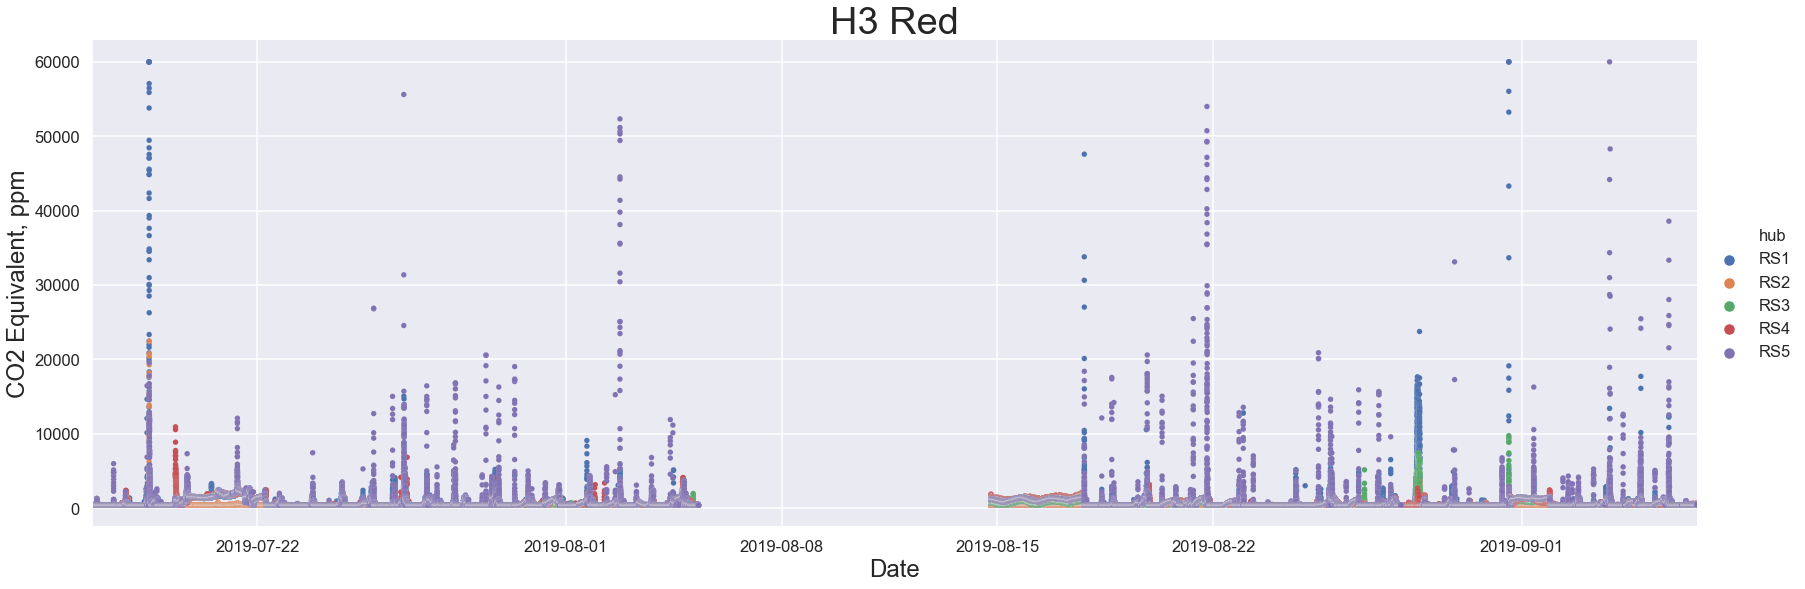

Plotting H2 Red relative humidity
Plotting H2 Red lux
Plotting H2 Red distance
Plotting H2 Red tvoc
Plotting H2 Red co2
Done plotting H2 Red
Plotting H5 Red relative humidity
Plotting H5 Red lux
Plotting H5 Red distance
Plotting H5 Red tvoc
Plotting H5 Red co2
Done plotting H5 Red
Plotting H3 Black relative humidity
Plotting H3 Black lux
Plotting H3 Black distance
Plotting H3 Black tvoc
Plotting H3 Black co2
Done plotting H3 Black


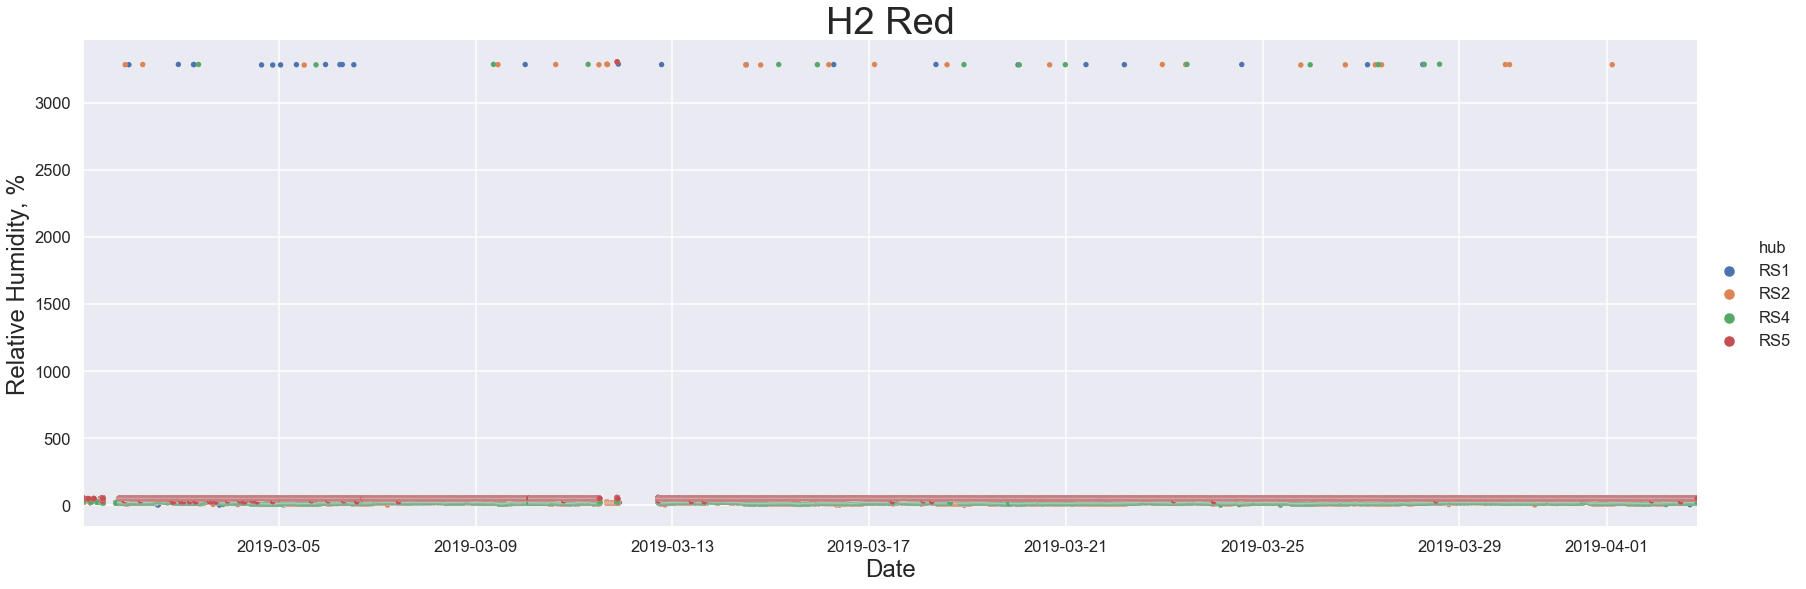

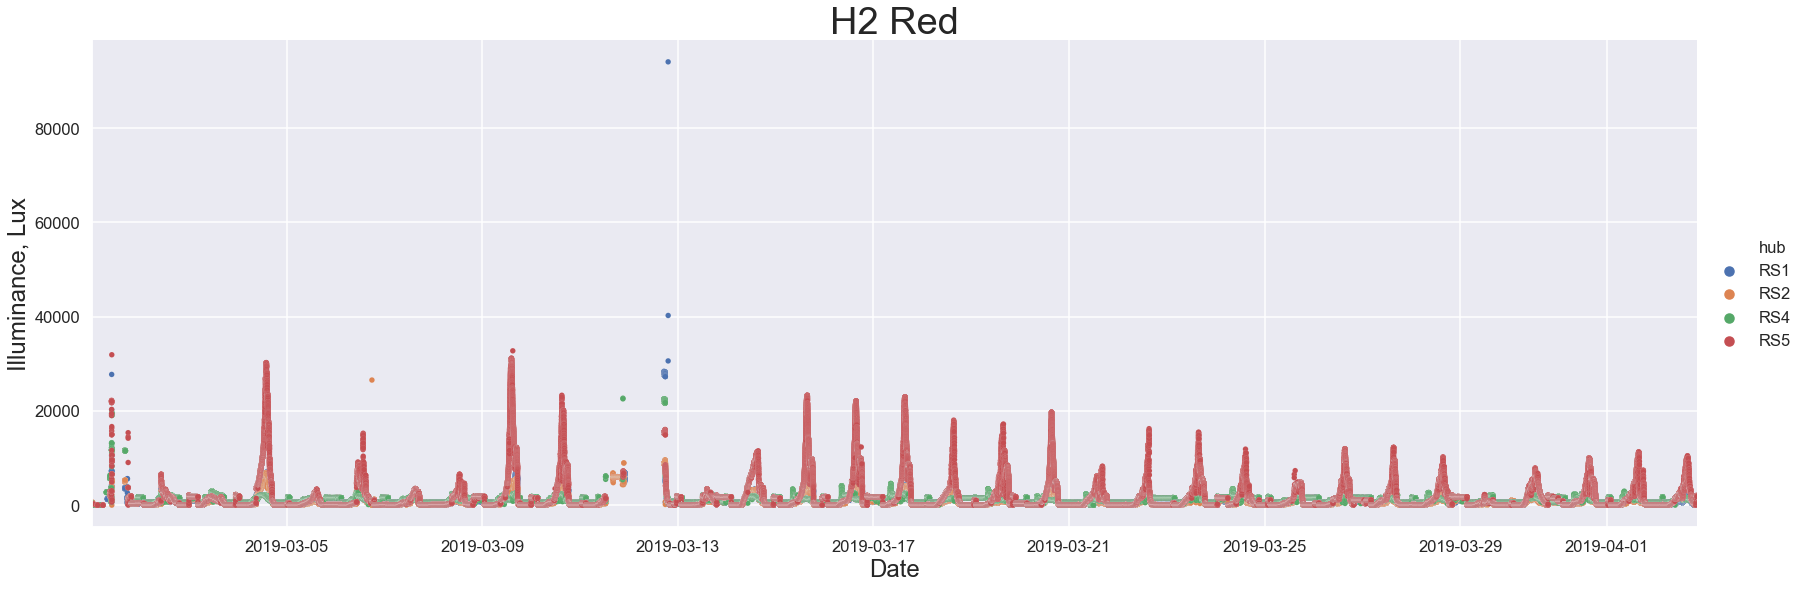

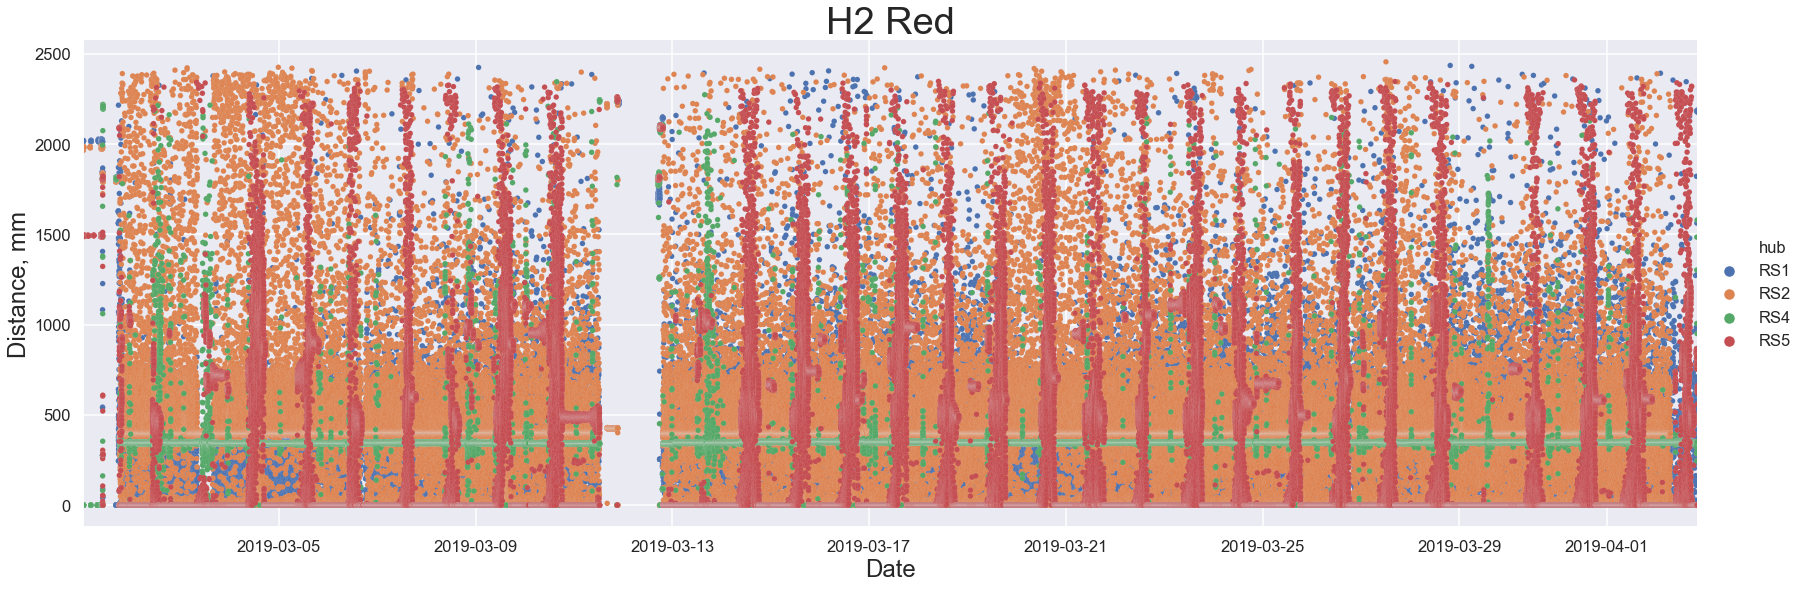

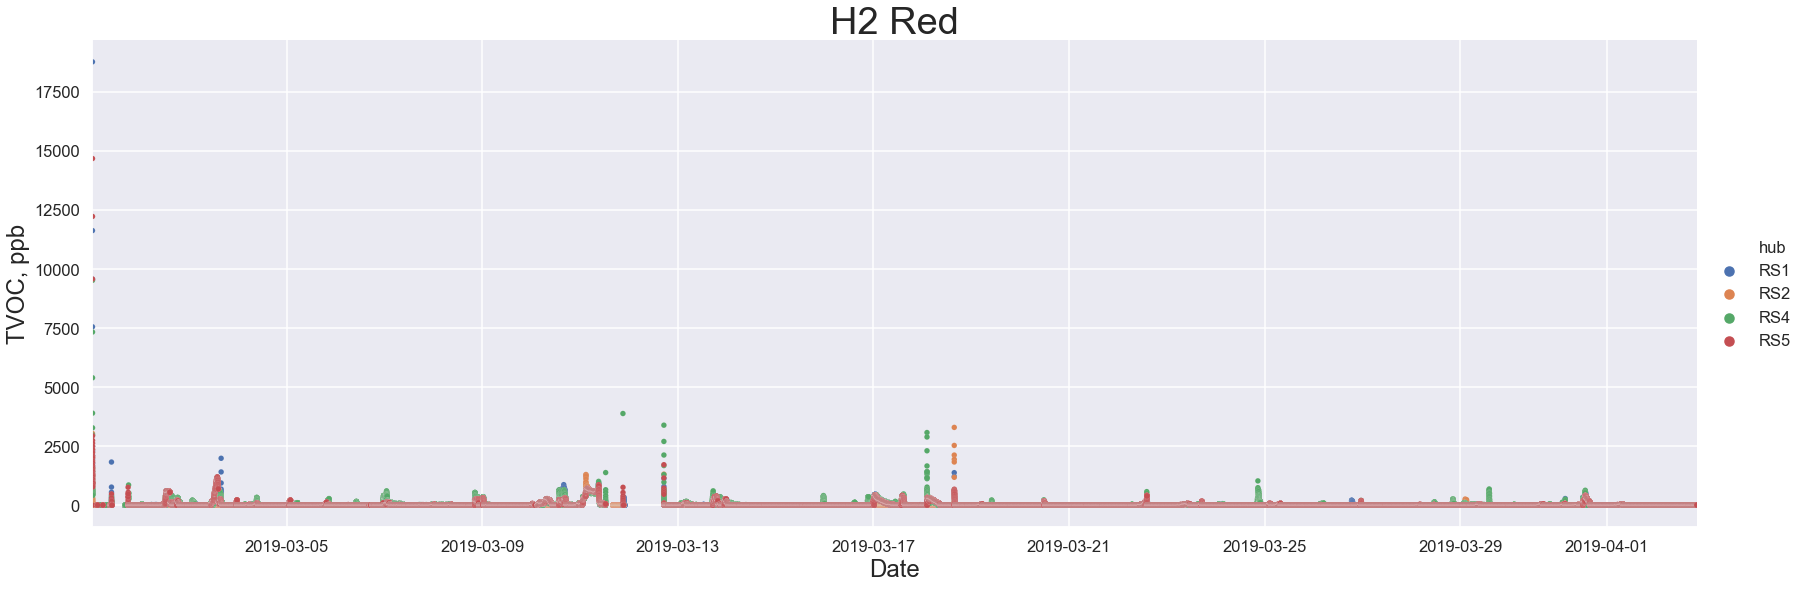

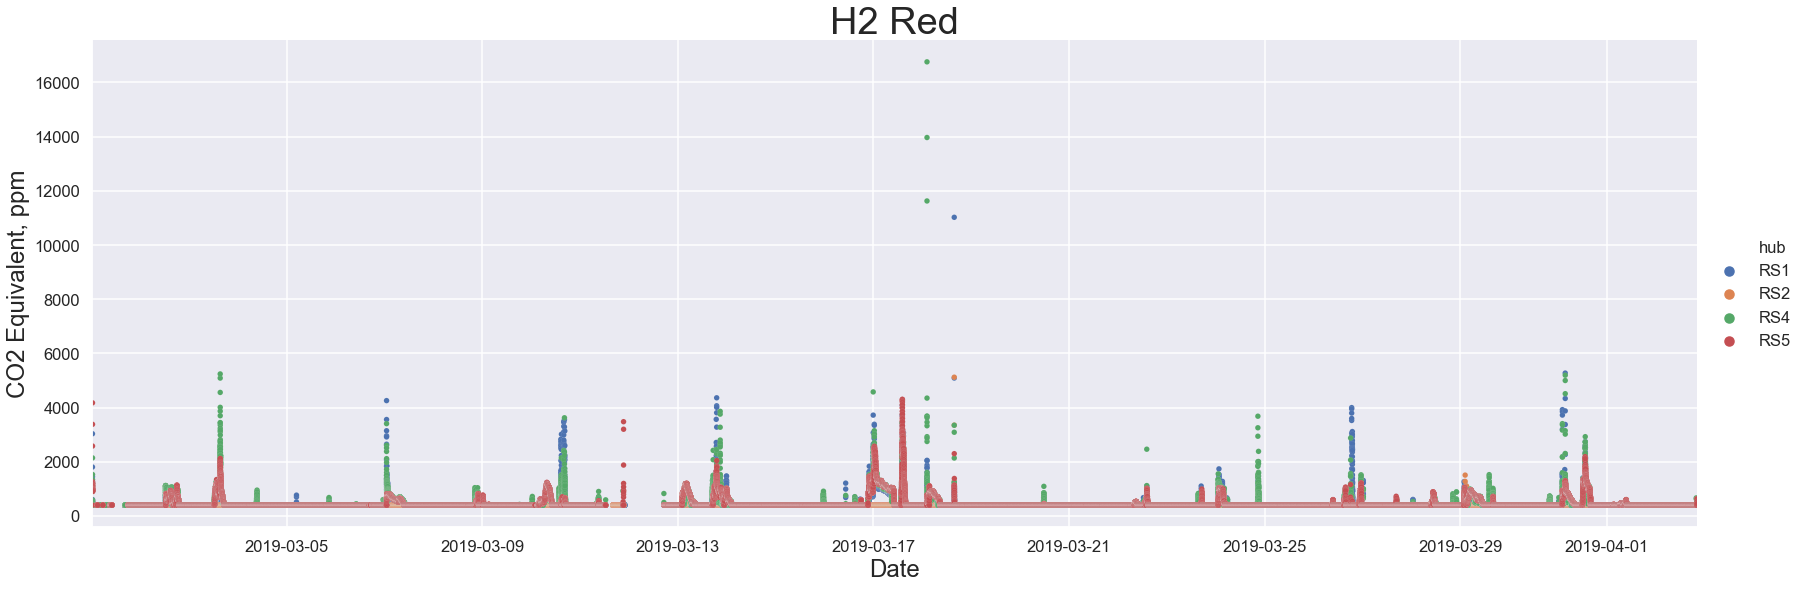

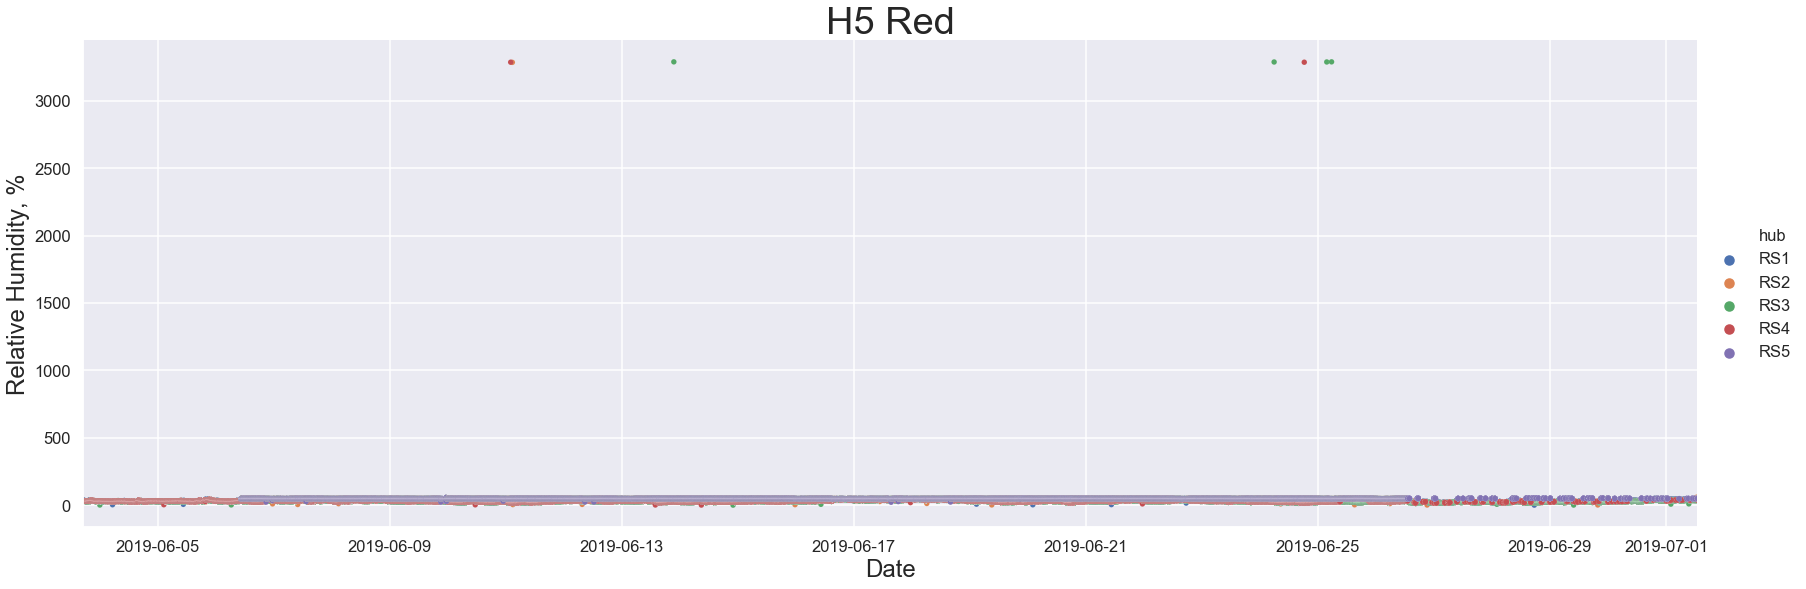

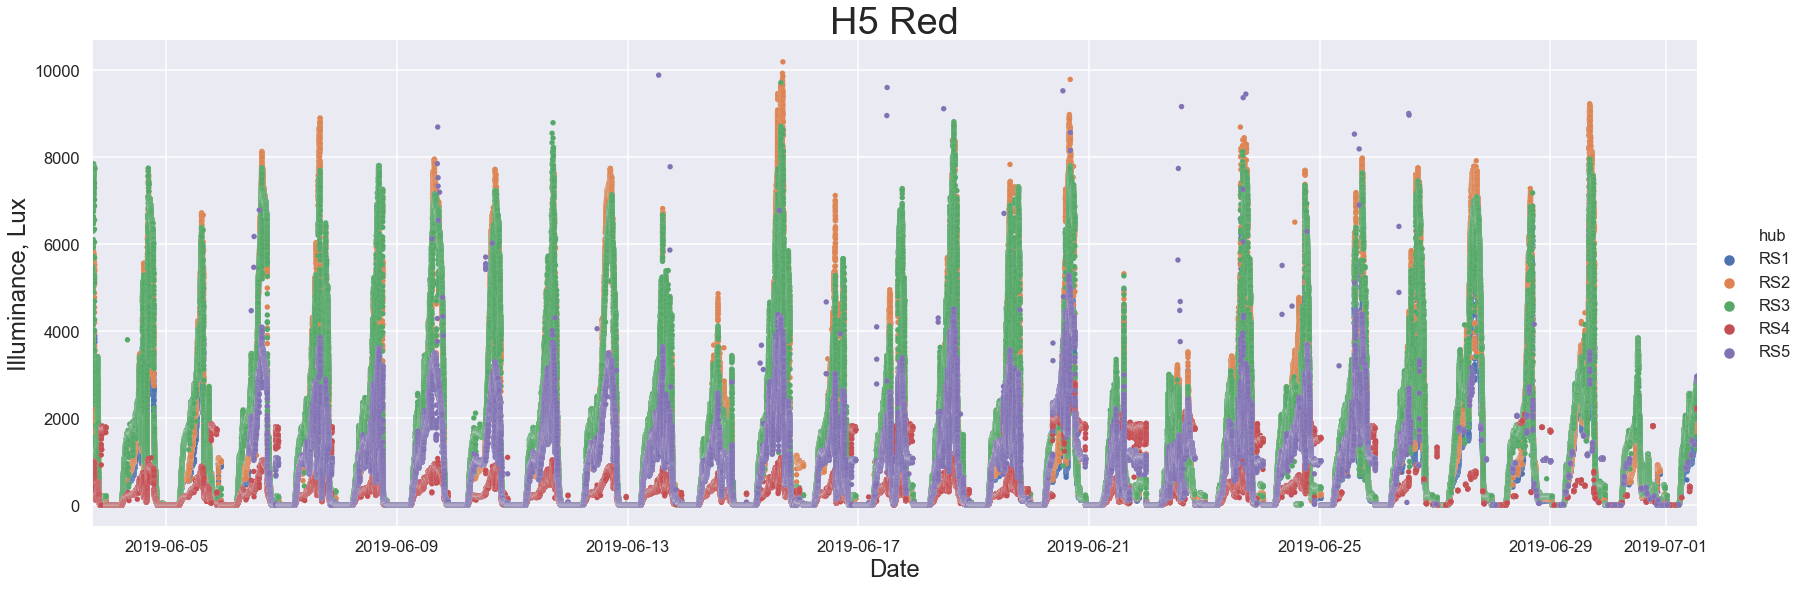

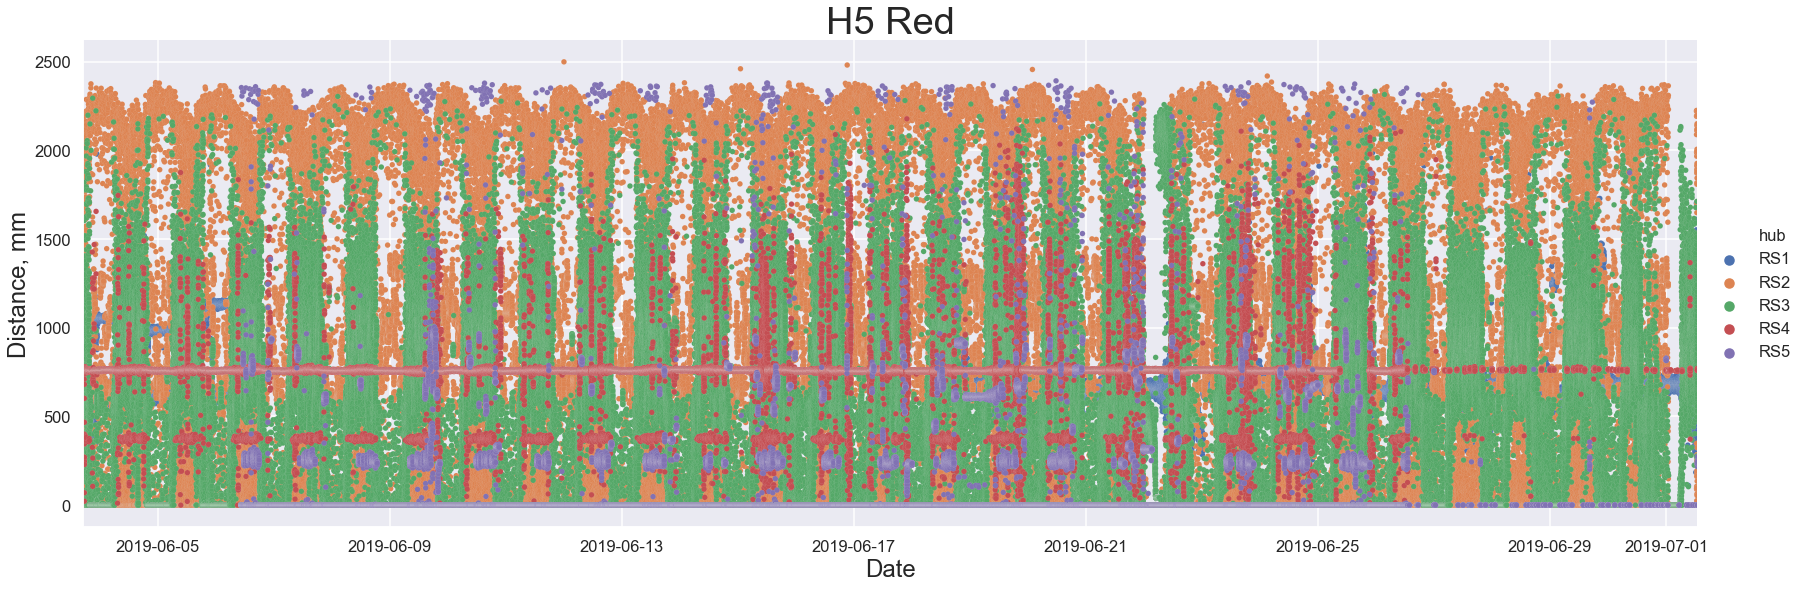

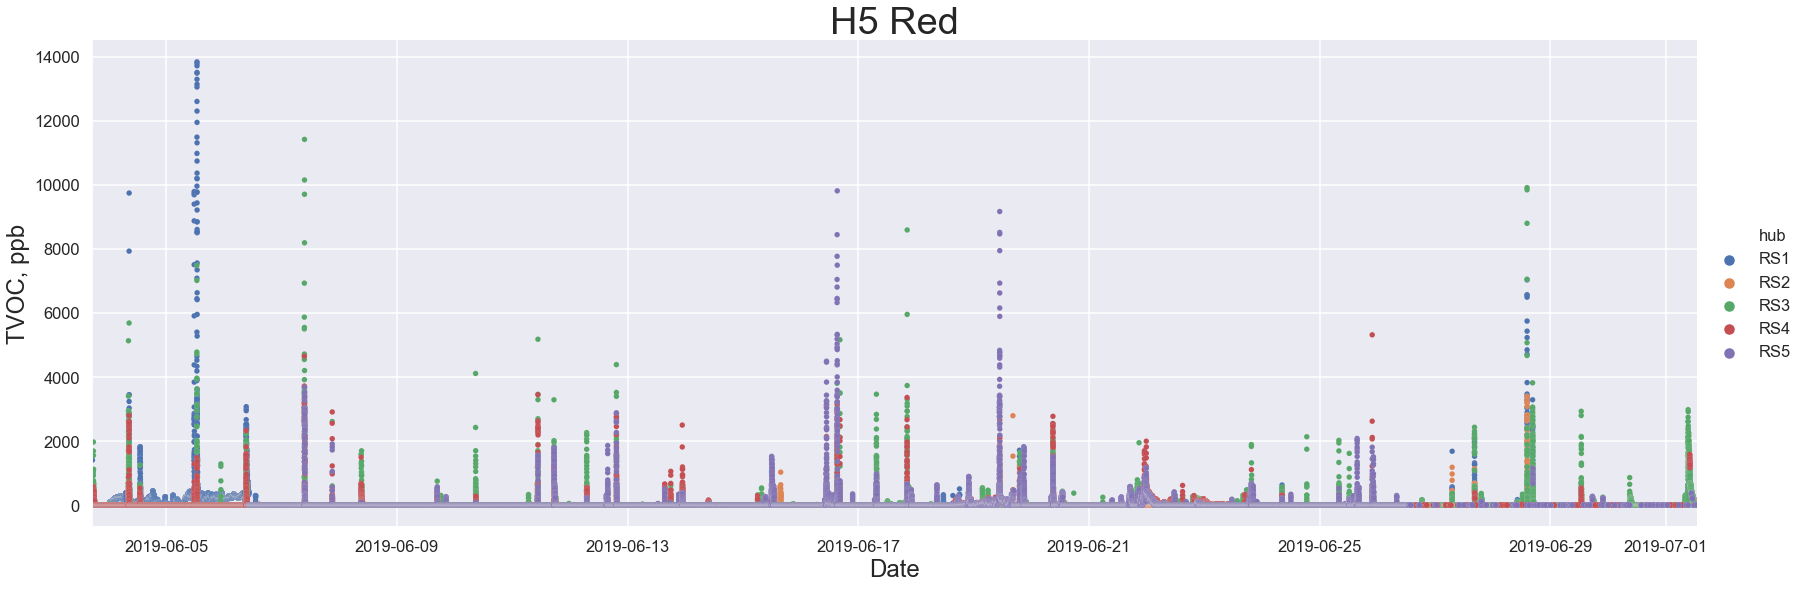

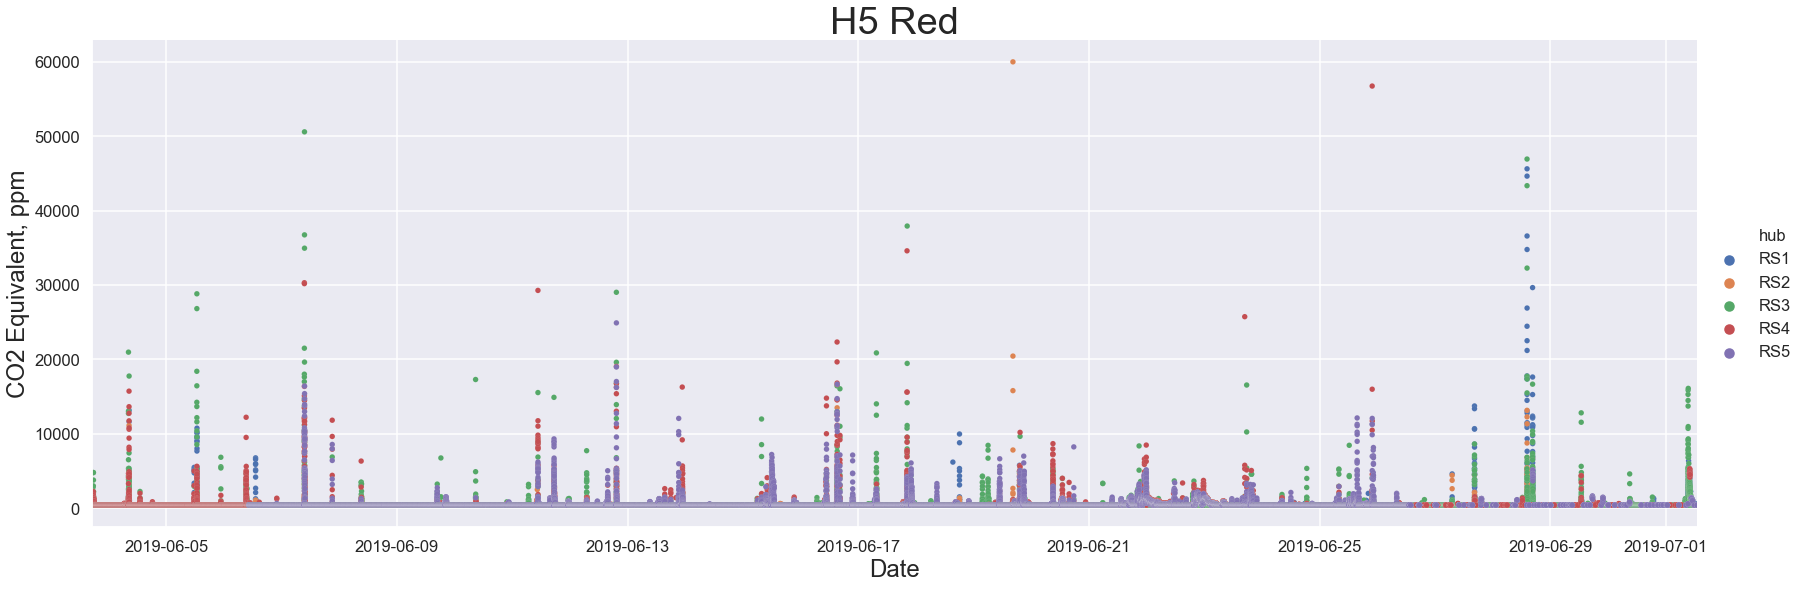

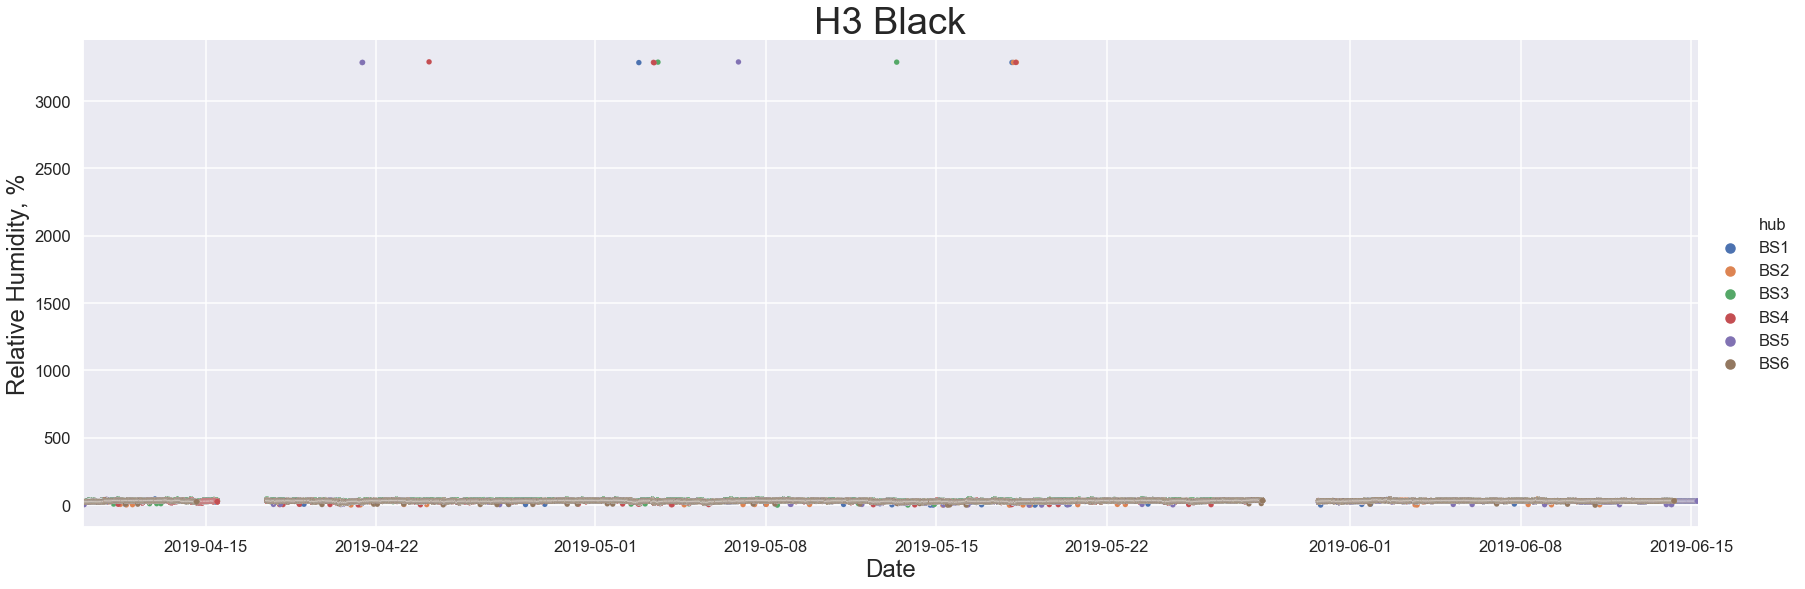

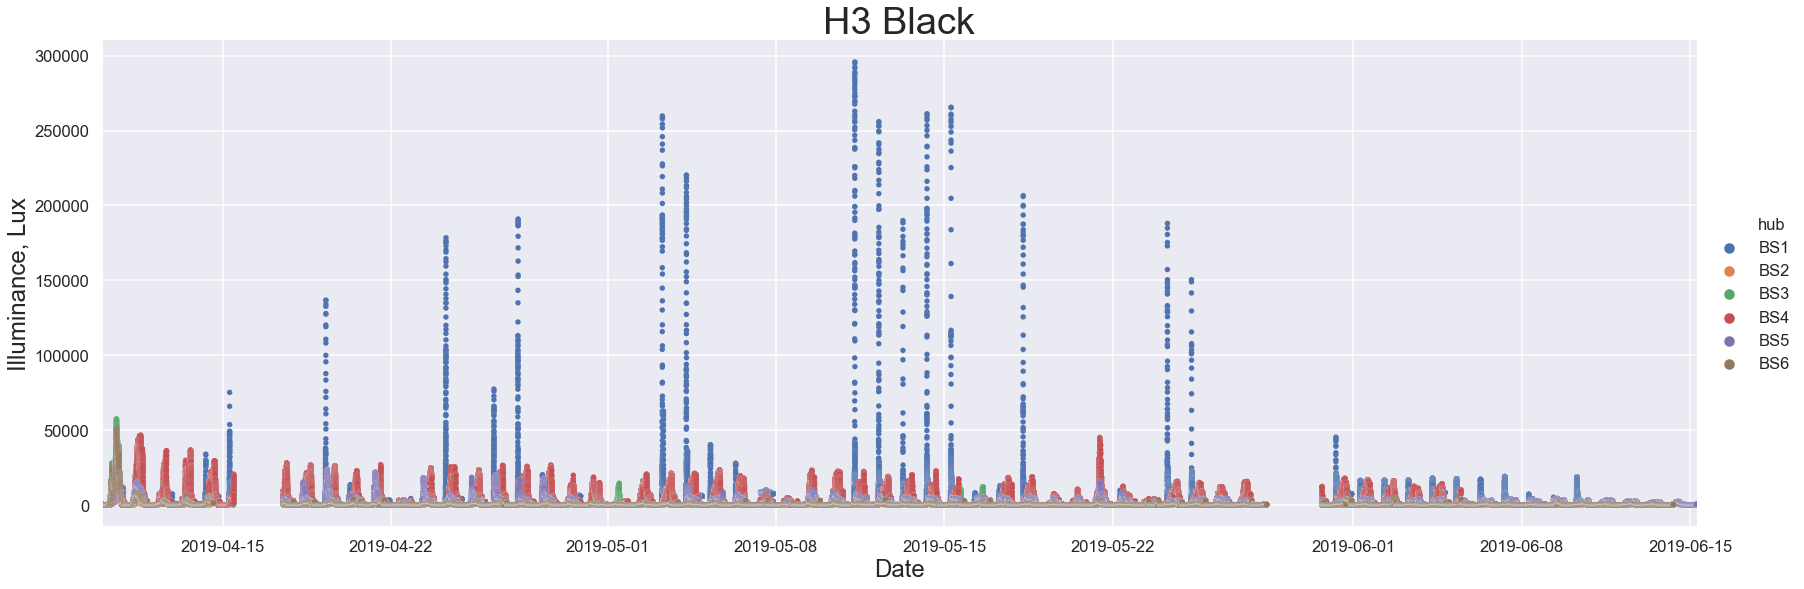

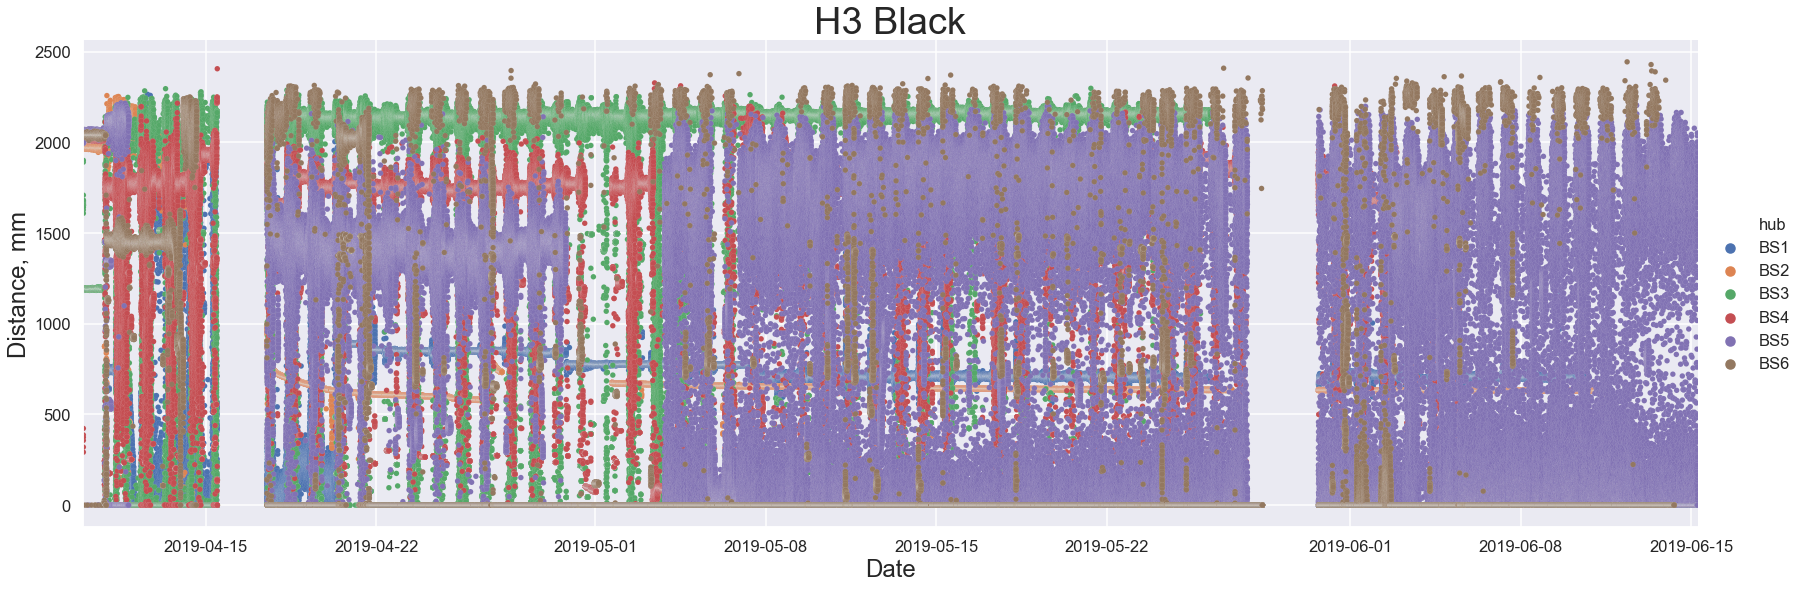

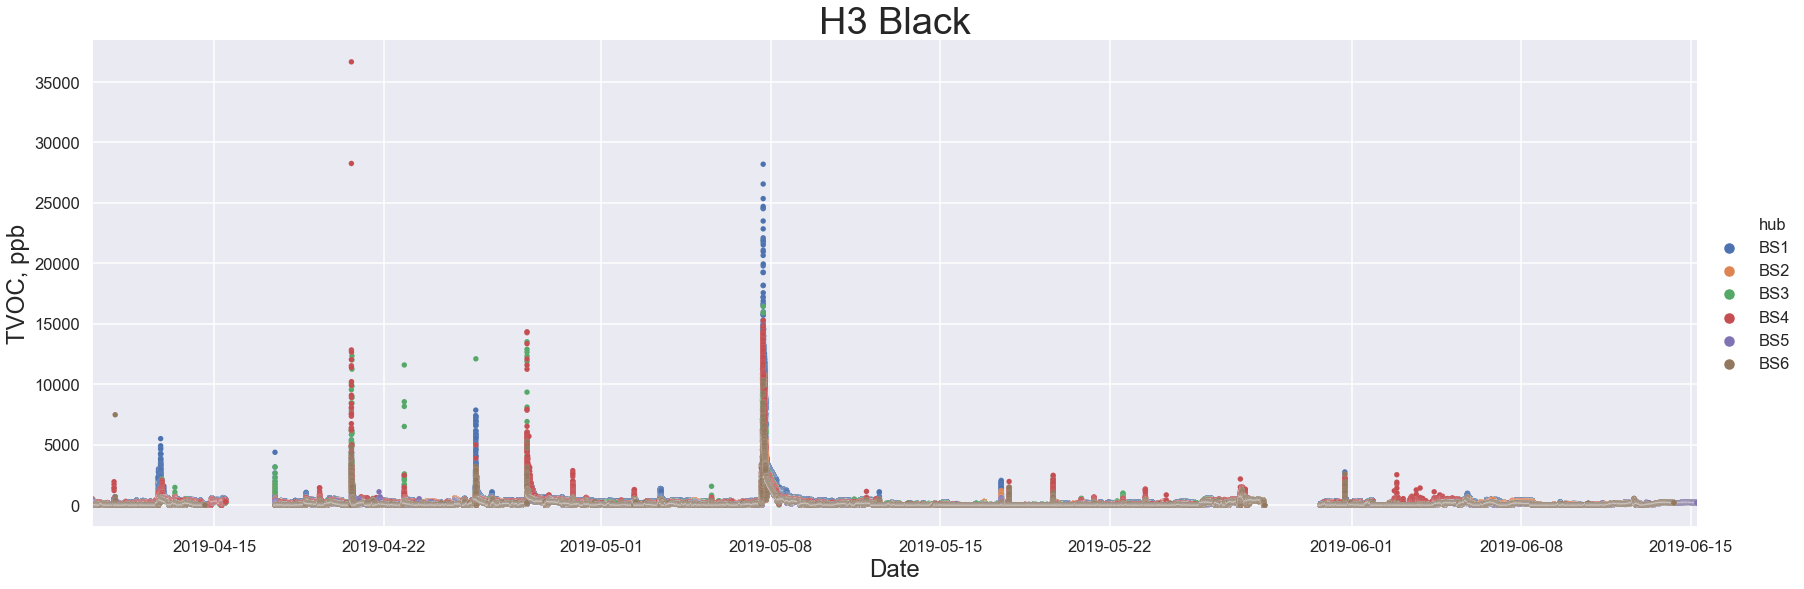

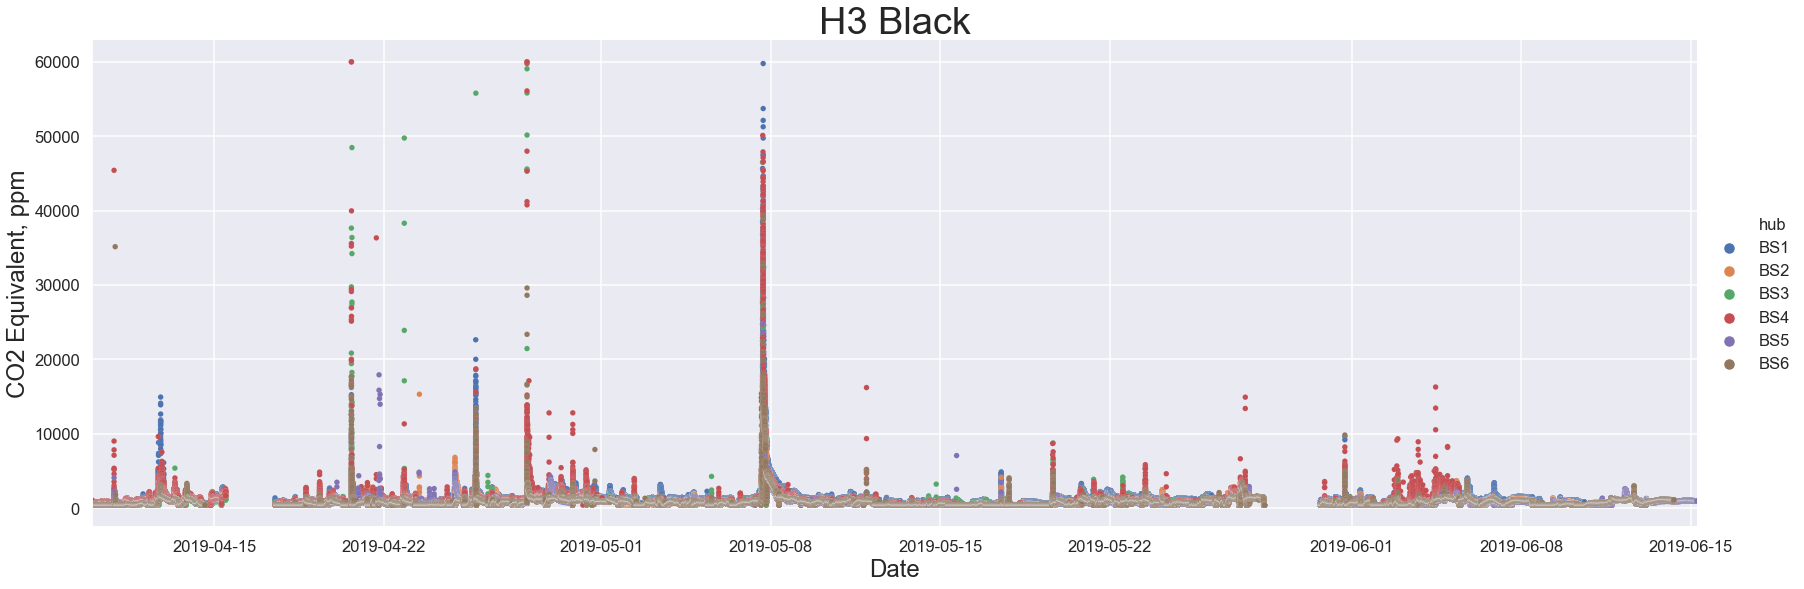

In [274]:
# PlotAll(H1_Black_Full, 'H1 Black', to_plot)
# PlotAll(H1_Red_Full, 'H1 Red', to_plot)
PlotAll(H2_Red_Full, 'H2 Red', to_plot)
PlotAll(H5_Red_Full, 'H5 Red', to_plot)
PlotAll(H3_Black_Full, 'H3 Black', to_plot)

ValueError: Could not interpret input 'co2_eq_ppm'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11599c5f0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x123e28f80> (for post_execute):


KeyboardInterrupt: 

In [258]:
def BoxTemps(df_full, name):
    df = df_full[df_full.temp_c > 15]
    ax = sns.boxplot(x='hub', y='temp_c', data=df);
    plt.xlabel('Hub', fontsize=24)
    plt.ylabel('Temperature C', fontsize=24)
    plt.title(name, fontsize=38)
    plt.savefig(f'/Users/maggie/Desktop/data_exploration_images/box/temp-{name}.png')

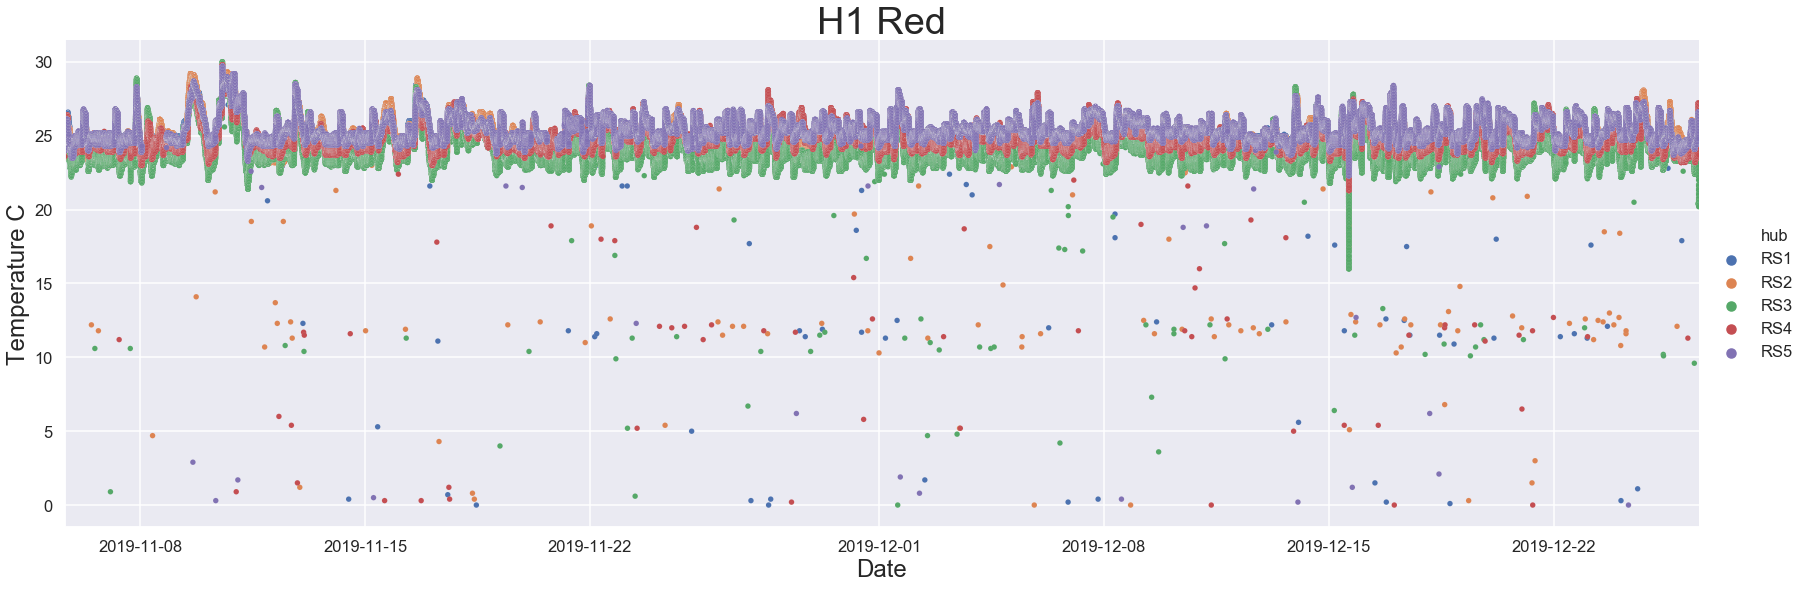

In [229]:
PlotTemps(H1_Red_Full, 'H1 Red')
PlotTemps(H1_Black_Full, 'H1 Black')
PlotTemps(H2_Red_Full, 'H2 Red')
PlotTemps(H3_Red_Full, 'H3 Red')
PlotTemps(H3_Black_Full, 'H3 Black')
PlotTemps(H5_Red_Full, 'H5 Red')

In [250]:
H1_Red_Full.columns

Index(['tvoc_ppb', 'temp_c', 'rh_percent', 'light_lux', 'co2eq_ppm', 'dist_mm',
       'co2eq_base', 'tvoc_base', 'home', 'hub', 'time'],
      dtype='object')

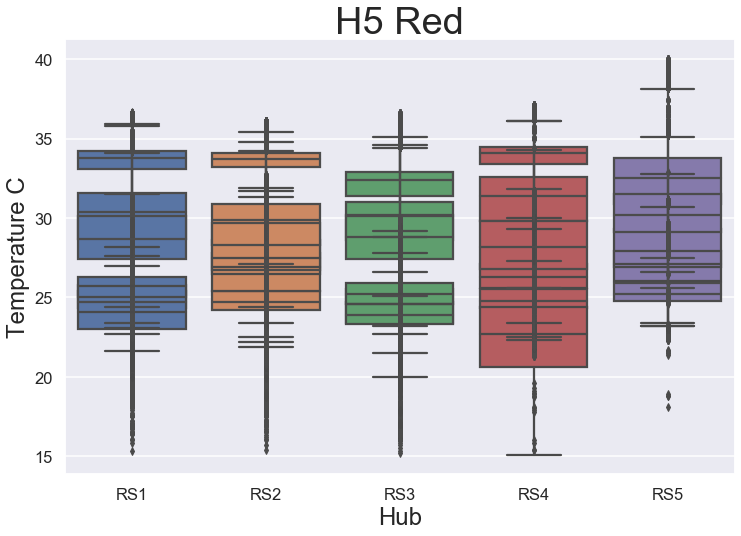

In [260]:
BoxTemps(H1_Red_Full, 'H1 Red')
BoxTemps(H1_Black_Full, 'H1 Black')
BoxTemps(H2_Red_Full, 'H2 Red')
BoxTemps(H3_Red_Full, 'H3 Red')
BoxTemps(H3_Black_Full, 'H3 Black')
BoxTemps(H5_Red_Full, 'H5 Red')

/Users/maggie/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



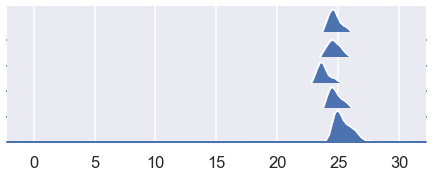

In [245]:
df = H1_Red_Full[['temp_c', 'hub']]

pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="hub", aspect=15, height=.5, palette=pal)
g.map(sns.kdeplot, "temp_c", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "temp_c", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.fig.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)